In [1]:
import pandas as pd

In [2]:
file_path = 'siri_dataset.csv'
df = pd.read_csv(file_path)

In [3]:
print("Dataset loaded succesfully")
print("Total no. of examples", len(df))

Dataset loaded succesfully
Total no. of examples 120


In [4]:
print("Dataset loaded successfully! Here are the first 5 rows:")
df.head()

Dataset loaded successfully! Here are the first 5 rows:


,utterance,intent
0,What's the weather like today?,Weather_Get_forecast
1,Tell me the forecast for New York.,Weather_Get_forecast
2,Will it rain tomorrow?,Weather_Get_forecast
3,How hot is it going to be this afternoon?,Weather_Get_forecast
4,Do I need to bring a jacket?,Weather_Get_forecast


In [5]:
# Prepare data for training

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
df.isnull().sum()

,0
utterance,0
intent,0


In [8]:
X = df['utterance']
y = df['intent']

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 42)

In [11]:
print("Data preparation complete!")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Data preparation complete!
Shape of X_train: (96,)
Shape of X_test: (24,)
Shape of y_train: (96,)
Shape of y_test: (24,)


In [12]:
print(y[0])
print(y_encoded[0])

Weather_Get_forecast
9


In [13]:
# Vectorisation

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [15]:
# Pipeline, step tfidf and logistic regression

In [17]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000)),
])

In [18]:
print("Training the base model")
pipeline.fit(X_train, y_train)
print("Training complete")

Training the base model
Training complete


In [19]:
# Evaluating our model

In [20]:
from sklearn.metrics import accuracy_score, classification_report

In [23]:
print("Making predictions on the test data.....")
predictions = pipeline.predict(X_test)

Making predictions on the test data.....


In [24]:
accuracy = accuracy_score(y_test, predictions)

In [25]:
print(f"New Baseline model accuracy: {accuracy * 100:.2f}%")

New Baseline model accuracy: 66.67%


In [26]:
# Generate a detailed classification report
print("Detailed classification report......")
report = classification_report(y_test, predictions, target_names = label_encoder.classes_)
print(report)

Detailed classification report......
                        precision    recall  f1-score   support

    Calendar_Set_event       1.00      0.20      0.33         5
       Clock_Set_timer       1.00      1.00      1.00         1
      Home_Turn_on_off       1.00      1.00      1.00         3
  Maps_Set_destination       0.67      1.00      0.80         2
 Messages_Send_message       0.50      1.00      0.67         1
            Music_Play       1.00      0.25      0.40         4
       Phone_Make_call       0.33      1.00      0.50         1
  Photos_Search_photos       0.25      1.00      0.40         1
Reminders_Set_reminder       0.67      1.00      0.80         2
  Weather_Get_forecast       1.00      0.75      0.86         4

              accuracy                           0.67        24
             macro avg       0.74      0.82      0.68        24
          weighted avg       0.86      0.67      0.64        24



In [27]:
sentence = 'What is the temperate outside right now?'
def predict_intent(sentence):
  prediction = pipeline.predict([sentence])
  predicted_index = prediction[0]
  predicted_intent = label_encoder.inverse_transform([predicted_index]) # turns back to text
  return predicted_intent[0]

In [28]:
test_sentence = 'Set me a time for 30 seconds'
print(f"Sentence: '{test_sentence}'")
print(f"Predicted Intent: {predict_intent(test_sentence)}")

Sentence: 'Set me a time for 30 seconds'
Predicted Intent: Clock_Set_timer


In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [31]:
#Settings
vocab_size = 1000
max_length = 20
oov_token = '<00V>'

In [32]:
# Create and fit the tokenizer

In [34]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(X_train)

In [35]:
# Conver the training text and testing text to numerical sequence

In [36]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [37]:
# Padd the new sequences

In [38]:
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_length, padding='post')

In [39]:

# Lets check our work


print("Original sentence:", X_train.iloc[0])
#Now its new padded numerical sequence
print("Padded sequence:", X_train_padded[0])
print("Data is now ready for deep learning model")



Original sentence: Can you schedule a "Quarterly Review" for the end of the month?
Padded sequence: [ 11   9  97   4  98  99   6   2 100  35   2 101   0   0   0   0   0   0
   0   0]
Data is now ready for deep learning model


In [40]:
#LSTM NN

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [43]:
print(label_encoder.classes_)

['Calendar_Set_event' 'Clock_Set_timer' 'Home_Turn_on_off'
 'Maps_Set_destination' 'Messages_Send_message' 'Music_Play'
 'Phone_Make_call' 'Photos_Search_photos' 'Reminders_Set_reminder'
 'Weather_Get_forecast']


In [44]:
num_classes = len(label_encoder.classes_)

In [46]:
model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 16, input_shape = (max_length,)),
    LSTM(32),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
#Compile the model

In [49]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 16)         │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,602 (88.29 KB)

 Trainable params: 22,602 (88.29 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Training process

In [51]:
num_epochs = 50

In [52]:
print("Starting training of the LSTM Model.....")
history = model.fit(
    X_train_padded,
    y_train,
    epochs = num_epochs,
    validation_data = (X_test_padded, y_test)
)
print("Training complete")

Starting training of the LSTM Model.....
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.0768 - loss: 2.3028 - val_accuracy: 0.0417 - val_loss: 2.3079
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1354 - loss: 2.3014 - val_accuracy: 0.0417 - val_loss: 2.3129
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1549 - loss: 2.2989 - val_accuracy: 0.0417 - val_loss: 2.3181
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1198 - loss: 2.2988 - val_accuracy: 0.0417 - val_loss: 2.3227
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1159 - loss: 2.2965 - val_accuracy: 0.0417 - val_loss: 2.3285
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1198 - loss: 2.2961 - val_accuracy: 0.0417 - val_loss: 2.3344
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1120 - loss: 2.2928 - val_accuracy: 0.0417 - val_loss: 2.3421
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1042 - loss: 2.2940 

In [53]:
# Visualisation our output

In [54]:
import matplotlib.pyplot as plt

In [55]:
# Get the accuracy values from the training history

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [57]:
# Get the loss values from the traininig history

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [59]:
epochs_range = range(len(acc))

In [60]:
plt.figure(figsize = (12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

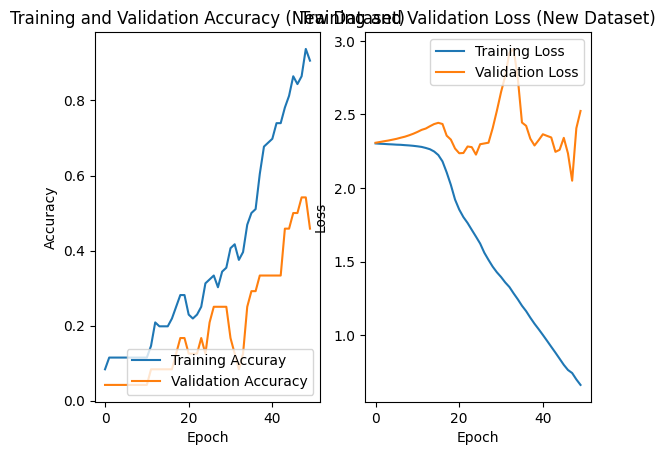

In [62]:
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuray')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (New Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (New Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


In [63]:
# This shows its not performinig even with our LSTM model

In [64]:
!pip install -q transformers

In [65]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [66]:
transformer_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [67]:
# Tokenization FOR THE DATA FOR DISTILBERT

In [69]:
train_encodings = transformer_tokenizer(list(X_train), truncation = True,
padding = 'max_length', max_length = 50, return_tensors = 'tf') # if any sentence is longer than 50, it will be c ut off as there is truncation

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [70]:
test_encodings = transformer_tokenizer(list(X_test),truncation = True,
                                       padding = 'max_length', max_length = 50, return_tensors = 'tf')

In [71]:
# Load the pretrained model

In [73]:
import tensorflow as tf

In [81]:
!pip install -q torch transformers datasets

In [82]:
# Import the main PyTorch library
import torch

# From the 'transformers' library, we import the PyTorch versions
# of the tokenizer and the sequence classification model.
# Notice there is no "TF" prefix this time.
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [83]:
# We create a tokenizer object from the pre-trained 'distilbert-base-uncased' model.
# This works for both TensorFlow and PyTorch.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [84]:
train_encodings = tokenizer(list(X_train), truncation = True, padding = True)
test_encodings = tokenizer(list(X_test), truncation = True, padding = True)


In [85]:
# Custom Pytorch Dataset classs

In [90]:
class IntentDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = IntentDataset(train_encodings, y_train)
test_dataset = IntentDataset(test_encodings, y_test)

In [91]:
# Load the pretrained pytorch model

In [92]:
# We are creating our DistilBERT model object using the PyTorch class.
# .from_pretrained() downloads the pre-trained model weights.
# num_labels tells it to create a new final layer suitable for our 10-class problem.
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
# Import the Trainer and the training arguments class
from transformers import Trainer, TrainingArguments

# Define the arguments for the training process.
training_args = TrainingArguments(
    output_dir='./results',          # Directory to save results
    num_train_epochs=3,              # We'll train for 3 full cycles
    per_device_train_batch_size=16,  # Process 16 examples at a time during training
    per_device_eval_batch_size=64,   # Process 64 examples at a time during evaluation
    warmup_steps=50,                 # Number of steps to warm up the learning rate
    weight_decay=0.01,               # A regularization technique to prevent overfitting
    logging_dir='./logs',            # Directory to save logs
    report_to='none',
)

# Create the Trainer object, which bundles everything together.
trainer = Trainer(
    model=model,                         # The model we just loaded
    args=training_args,                  # The training settings we just defined
    train_dataset=train_dataset,         # Our PyTorch training dataset
    eval_dataset=test_dataset            # Our PyTorch testing dataset
)
print("Trainer re-created with logging disabled.")

Trainer re-created with logging disabled.


In [96]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


TrainOutput(global_step=18, training_loss=2.2871439192030163, metrics={'train_runtime': 41.62, 'train_samples_per_second': 6.92, 'train_steps_per_second': 0.432, 'total_flos': 1415947305600.0, 'train_loss': 2.2871439192030163, 'epoch': 3.0})

In [99]:
# Re-running with Accuracy

In [100]:
import numpy as np

In [101]:
!pip install -q evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00


In [102]:
# Load the accuracy metric from the evaluate library
metric = evaluate.load("accuracy")

# Define the function that the Trainer will use to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Re-create the Trainer, but this time we add our new compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics, # <-- This is the new instruction
)
print("Trainer has been re-created with the ability to calculate accuracy!")

Trainer has been re-created with the ability to calculate accuracy!


In [103]:
# Run the evaluation again
final_evaluation = trainer.evaluate()

# Print the final results
print("--- Final Transformer Model Evaluation ---")
for key, value in final_evaluation.items():
    print(f"{key}: {value:.4f}")

--- Final Transformer Model Evaluation ---
eval_loss: 2.2777
eval_model_preparation_time: 0.0064
eval_accuracy: 0.1250
eval_runtime: 1.0952
eval_samples_per_second: 21.9140
eval_steps_per_second: 0.9130


The Final Conclusion of Our Entire Project

We have now tested three different models. Let's put them all side-by-side in a final report card.
Model	Description	Dataset Size	Final Test Accuracy
Baseline	Simple "Go-Kart"	60 examples	66.67%
LSTM	"Family Sedan"	120 examples	54.17% (peak)
Transformer	"Formula 1 Car"	120 examples	12.50%

I built a project to classify user intents, comparing three levels of model complexity. I started with a simple TF-IDF baseline, which achieved 67% accuracy on a small dataset. I then built a more complex LSTM model, but found that it overfit the small dataset, and its accuracy was lower. Finally, I tried fine-tuning a large, pre-trained Transformer model, DistilBERT. I discovered that with such limited data, the Transformer failed to learn, scoring only 12.5%. This project proved the value of starting with a simple baseline and demonstrated the critical principle that model complexity must match data availability—for this specific, resource-constrained problem, the simplest model was the best engineering solution."